In [30]:
import pandas as pd
import os
import numpy as np
df = pd.read_csv("data/clean_data.csv")
df_fe2 = df.copy()

if 'Currency' in df_fe2.columns:
    df_fe2['Is_USD'] = (df_fe2['Currency'] == 'USD').astype(int)

branch_cols = [col for col in df_fe2.columns if col.startswith('Branch_') and col != 'Branch_Size']

branch_freqs = df_fe2[branch_cols].sum() / len(df_fe2)

def assign_branch_weight(row):
    for branch in branch_cols:
        if row[branch] == 1:
            return branch_freqs[branch]
    return 0.0

df_fe2['Branch_Frequency_Weight'] = df_fe2.apply(assign_branch_weight, axis=1)

df_fe2 = df_fe2.drop(columns=[col for col in df_fe2.columns 
                              if (col.startswith('Branch_') and col != 'Branch_Frequency_Weight') 
                              or col.startswith('Currency_')])

if 'Branch_Size' in df_fe2.columns:
    df_fe2 = df_fe2.drop(columns='Branch_Size')

for col in ['Branch', 'Currency']:
    if col in df_fe2.columns:
        df_fe2 = df_fe2.drop(columns=col)

transaction_cols = [col for col in df_fe2.columns if col.startswith('Account_Transaction_')]
weights = [round(i, 2) for i in np.linspace(0.14, 1.0, len(transaction_cols))]  # 7 wag

for col, weight in zip(transaction_cols, weights):
    df_fe2[col] = df_fe2[col] * weight

df_fe2['Account_Transaction_Encoded'] = df_fe2[transaction_cols].sum(axis=1)

df_fe2 = df_fe2.drop(columns=transaction_cols)

        
print(df_fe2.head())


   Transaction Amount  Account Balance  Transaction_To_Balance_Ratio  \
0            0.536443         0.366206                      0.073268   
1            0.776897         0.285169                      0.135983   
2            0.486642         0.765944                      0.031838   
3            0.550743         0.622944                      0.044266   
4            0.656674         0.855213                      0.038438   

   Is_High_Value_Transaction  High_Balance_flag  Branch_Frequency_Weight  \
0                          0                  0                   0.1256   
1                          1                  0                   0.1259   
2                          0                  1                   0.1256   
3                          0                  0                   0.1288   
4                          0                  1                   0.1288   

   Account_Transaction_Encoded  
0                         0.71  
1                         0.71  
2          

In [31]:
os.makedirs('data', exist_ok=True)
df_fe2.to_csv('data/final_data_fe2.csv', index=False)


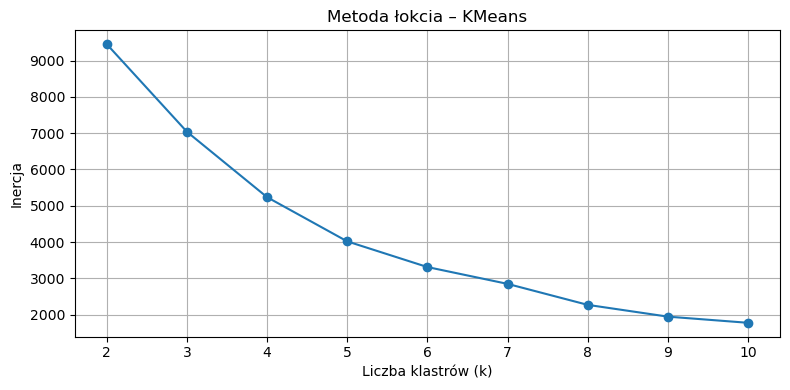

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_fe2)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Metoda łokcia – KMeans')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
k = 5 
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_fe2['KMeans_FE2'] = kmeans.fit_predict(df_fe2)


In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_only = df_fe2.drop(columns='KMeans_FE2')
sil_score = silhouette_score(X_only, df_fe2['KMeans_FE2'])
db_score = davies_bouldin_score(X_only, df_fe2['KMeans_FE2'])

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f} ")


Silhouette Score: 0.469
Davies-Bouldin Score: 0.750 


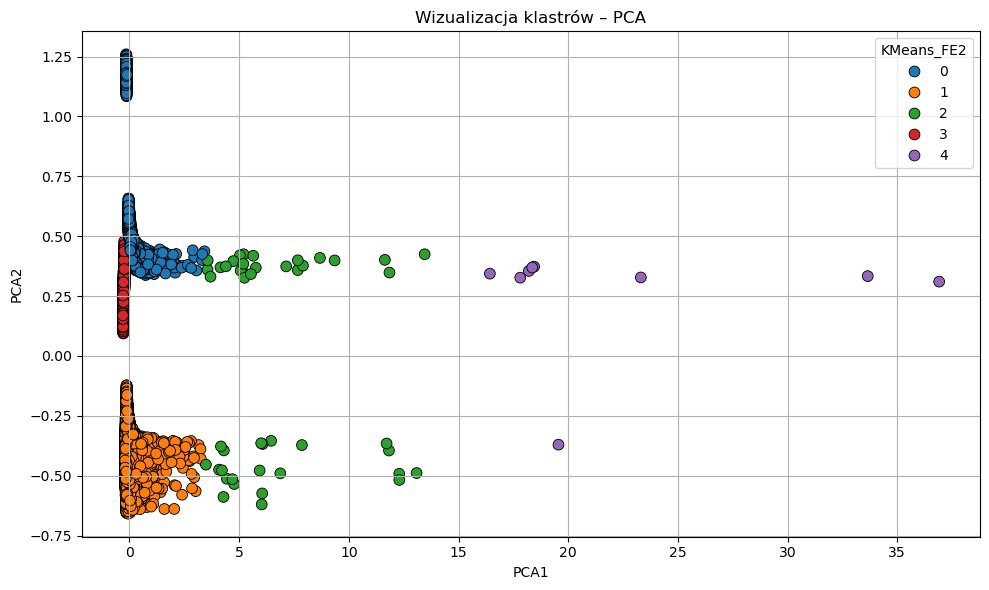

In [35]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_only)

df_fe2['PCA1'] = X_pca[:, 0]
df_fe2['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fe2, x='PCA1', y='PCA2', hue='KMeans_FE2', palette='tab10', s=60, edgecolor='black')
plt.title('Wizualizacja klastrów – PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


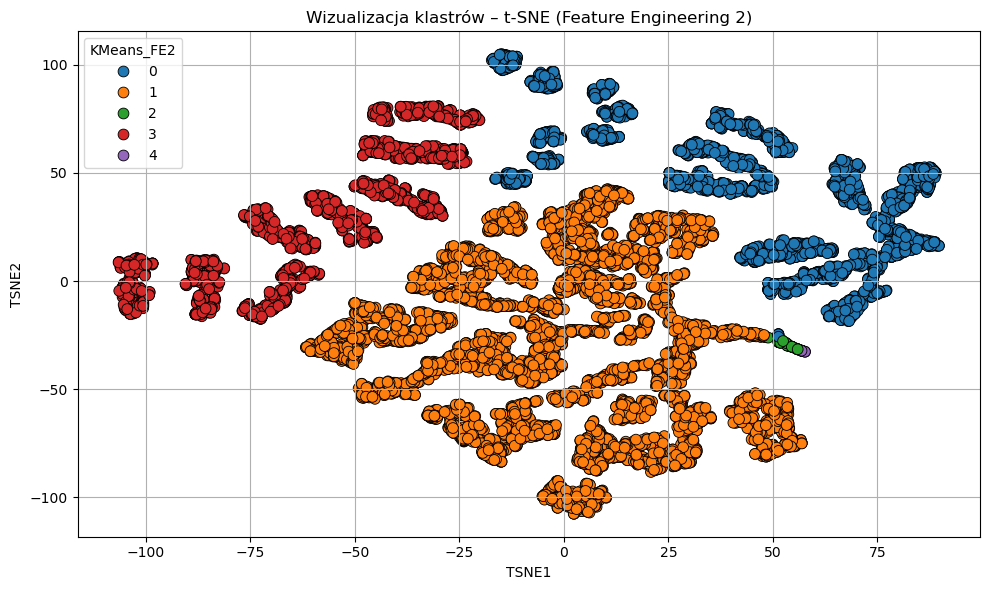

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_tsne_input = df_fe2.drop(columns=['KMeans_FE2'])

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

df_fe2['TSNE1'] = X_tsne[:, 0]
df_fe2['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_fe2,
    x='TSNE1',
    y='TSNE2',
    hue='KMeans_FE2',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('Wizualizacja klastrów – t-SNE (Feature Engineering 2)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
cluster_profile = df_fe2.groupby('KMeans_FE2').mean().T.round(2)
display(cluster_profile)


KMeans_FE2,0,1,2,3,4
Transaction Amount,0.88,0.38,0.70,0.38,0.81
Account Balance,0.50,0.38,0.00,0.88,0.00
Transaction_To_Balance_Ratio,0.19,0.13,6.85,0.02,22.79
Is_High_Value_Transaction,1.00,0.00,0.52,0.00,0.89
High_Balance_flag,0.25,0.00,0.00,1.00,0.00
Branch_Frequency_Weight,0.11,0.11,0.12,0.11,0.13
Account_Transaction_Encoded,0.50,0.50,0.47,0.50,0.38
PCA1,0.08,-0.04,6.70,-0.26,22.52
PCA2,0.66,-0.39,-0.02,0.29,0.26
TSNE1,44.45,0.01,53.36,-60.52,57.03


---

### **0 – Zamożni i aktywni użytkownicy**
**Charakterystyka:**
- Wysoka wartość transakcji (`0.88`)
- Umiarkowany stan konta (`0.50`)
- Bardzo niski wskaźnik transakcji do salda (`0.19`)
- *Wszyscy* wykonują duże transakcje (`1.00`)
- Umiarkowany odsetek klientów z wysokim saldem (`0.25`)
- Średnia aktywność transakcyjna (`0.50`)

*Interpretacja:* Aktywni klienci o stosunkowo wysokiej sile nabywczej i stabilnych zasobach. Cenny segment premium.

---

### **1 – Pasywni i niskowartościowi klienci**
**Charakterystyka:**
- Niskie saldo (`0.38`) i niska wartość transakcji (`0.38`)
- Brak dużych transakcji (`0.00`)
- Bardzo niski współczynnik transakcji do salda (`0.13`)
- Brak klientów z wysokim saldem
- Średnia aktywność transakcyjna (`0.50`)

*Interpretacja:* Klienci niewartościowi z punktu widzenia banku. Utrzymywani, ale pasywni.

---

### **2 – Przeciążeni użytkownicy / potencjalnie zadłużeni**
**Charakterystyka:**
- Średnia wartość transakcji (`0.70`) przy *zerowym saldzie*
- **Ekstremalny** wskaźnik transakcji do salda (`6.85`)
- Połowa wykonuje duże transakcje (`0.52`)
- Brak klientów z wysokim saldem (`0.00`)
- Lekko poniżej średniej aktywność transakcyjna (`0.47`)

*Interpretacja:* Klienci z bardzo wysoką aktywnością i brakiem środków – możliwe zadłużenie lub intensywne operacje bez pokrycia. Kandydaci do kredytów lub windykacji.

---

### **3 – Bogaci i pasywni**
**Charakterystyka:**
- Niska aktywność transakcyjna (`0.38`)
- *Najwyższe saldo* (`0.88`)
- **Najniższy** wskaźnik transakcji do salda (`0.02`)
- Brak dużych transakcji
- *100%* klientów z wysokim saldem
- Średnia aktywność transakcyjna (`0.50`)

*Interpretacja:* Klienci zamożni, ale nieaktywni – przechowują środki. Dobry target dla ofert inwestycyjnych lub produktów oszczędnościowych.

---

### **4 – Intensywnie operujący bez pokrycia**
**Charakterystyka:**
- Wysoka wartość transakcji (`0.81`) przy *zerowym saldzie*
- **Bardzo wysoki** współczynnik transakcji do salda (`22.79`)
- *Prawie wszyscy* wykonują duże transakcje (`0.89`)
- Brak klientów z wysokim saldem (`0.00`)
- Najniższa aktywność transakcyjna (`0.38`)

*Interpretacja:* Użytkownicy skrajnie intensywni, prawdopodobnie z kontami w trybie kredytowym lub intensywnie „przewijający” środki. Potencjalne ryzyko lub klienci spekulacyjni.

---